In [2]:
from wsmtk.whittaker import *
import numpy as np
import pandas as pd
import glob
import re
import array
import matplotlib.pyplot as plt
import datetime
import h5py
#import ee
%config Completer.use_jedi=False

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
## helper functions
def fromjulian(x):
    '''Parses julian date string to datetime object.'''

    return datetime.datetime.strptime(x,'%Y%j').date()


In [7]:
coords = pd.read_csv('/data/whittaker_signatures/final_test/FinalTest.csv')

In [9]:
pts_aqua = pd.read_csv('/data/whittaker_signatures/final_test/final-test-MYD13A1-006-results.csv')

In [10]:
pts_terra  = pd.read_csv('/data/whittaker_signatures/final_test/final-test-MOD13A1-006-results.csv')

array(['P1a', 'P1b', 'P2a', 'P2b', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8a',
       'P8b', 'P9', 'P10', 'P11', 'P12a', 'P12b', 'P17', 'P18'],
      dtype=object)

In [64]:
df = pd.DataFrame(index=None)
ix = 0
for pix in coords.ID.values:
    ix +=1
    lon = coords['Lon'][coords['ID']==pix].values[0].round(3)
    lat = coords['Lat'][coords['ID']==pix].values[0].round(3)
    
    
    subset_aq = pts_aqua[(pts_aqua.Latitude.round(3) == lat) & (pts_aqua.Longitude.round(3) == lon)]
    subset_aq.Date = pd.to_datetime(subset_aq.Date)
   
    
    subset_tr = pts_terra[(pts_terra.Latitude.round(3) == lat) & (pts_terra.Longitude.round(3) == lon)]
    subset_tr.Date = pd.to_datetime(subset_tr.Date)
    
    
    subset_tr = subset_tr[subset_tr.Date >= fromjulian('2002177')]
    
    
    dts_aq = [datetime.datetime.strptime(str(x).split('T')[0],'%Y-%m-%d').date().strftime('%Y%j') for x in subset_aq.Date.values]
    dts_tr = [datetime.datetime.strptime(str(x).split('T')[0],'%Y-%m-%d').date().strftime('%Y%j') for x in subset_tr.Date.values]
        
    
    
    dts = np.concatenate([dts_tr,dts_aq])
    
    #print(dts)
    
    
    
    
    ndvi = np.concatenate([subset_tr.MOD13A1_006__500m_16_days_NDVI.values,subset_aq.MYD13A1_006__500m_16_days_NDVI.values])
    
    ndvi_srt = np.array([x for (y,x) in sorted(zip(dts,ndvi))])
    
    dts.sort()
    
    if ix == 1:
        df['ID'] =  pd.concat([pd.Series(['Lat','Lon']),pd.Series(dts)],ignore_index=True)
        
    df[pix] = pd.concat([pd.Series([lat,lon]),pd.Series(ndvi_srt)],ignore_index=True)
    
    

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.


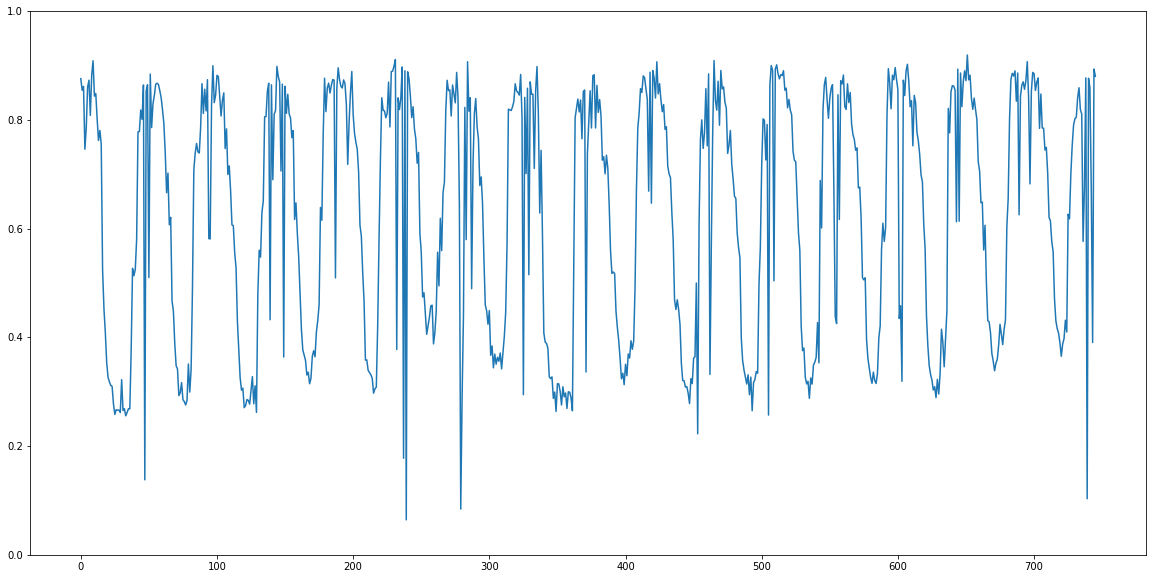

In [72]:
plt.figure(figsize=(20,10))
plt.ylim(0,1)
plt.plot(df.P2b.values[2:])
#plt.plot(df.P18.values[2:])

In [60]:
df.to_csv('/data/whittaker_signatures/final_test/FinalTest_EXTRACT.csv')

In [44]:
def smooth(x,pval=None):
    y = np.array(x,dtype='float32')
    srange = np.linspace(-2.0,4.0,31.0)
    
    w = np.array((y != -3000)*1,dtype='float32')  
    
    if pval:
        z, lopt = ws2d_vc(y,w,array.array('f',srange))
        sr2 = srange[srange<=np.log10(lopt)]
        
        if len(sr2)==2:
            sr2 = np.concatenate([sr2-0.2,sr2])
        
        z, lopt = ws2d_vc_asy(y,w,array.array('f',sr2),p=pval)
    else:
        z, lopt = ws2d_vc(y,w,array.array('f',srange))
    return(z,lopt)

In [61]:
#rawp = pd.read_excel('/data/whittaker_signatures/pre_wash/NDVIPreWash.xlsx',sheet_name='Iter1',)
rawp = df

In [62]:
for p in [None,0.90,0.80,0.95]:#[0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0]:
    
    df = pd.DataFrame(index=range(len(rawp)+2))

    #df['ID'] = pd.concat([pd.Series(['Lon','Lat']),pd.Series(rawp['DATES'].values[2:]),pd.Series(['Sopt','logSopt'])],ignore_index=True)

    df['ID'] = pd.concat([rawp['ID'],pd.Series(['Sopt','logSopt'])],ignore_index=True)

    for pix in coords.ID.values:
    
        rts = rawp[pix].values[2:]
    
        z, lopt = smooth(rts,pval=p)
    
        df[pix] = pd.concat([pd.Series(rawp[pix].values[0:2]),pd.Series(z),pd.Series([lopt,np.log10(lopt)])],ignore_index=True)
        
    if not p:
        p = 'NONE'
    fn = '/data/whittaker_signatures/final_test/FINALTEST_vcurve-2step_p_{}.csv'.format(p)
    
    df.to_csv(fn)
    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#z, lopt = smooth(rts,pval=0.9)

In [ ]:
rts = rawp.P9[2:].values

In [ ]:
z1 = df.P9.values[2:-2]

In [ ]:
z2,lopt = smooth(rts,pval=0.95)

In [ ]:
plt.figure(figsize=(20,10))
plt.ylim(0,1)
plt.plot(rts)
plt.plot(z1)
#plt.plot(ss.Date.values,ss['MOD13A1_006__500m_16_days_NDVI'].values,'ro')
#plt.plot(z2)

In [ ]:

plt.figure(figsize=(20,10))
plt.ylim(0.1)
z,lopt = smooth(rawp.P27[2:].values,0.95)
#plt.plot(rawp.P14[26:72].values)
plt.plot(rawp.P27[2:].values)
plt.plot(z)